# Gamma Regression (California Housing Data)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/StatMixedML/XGBoostLSS/blob/master/docs/examples/Gamma_Regression_CaliforniaHousing.ipynb)

# Imports

In [18]:
from xgboostlss.model import *
from xgboostlss.distributions.Gamma import *
from xgboostlss.distributions.LambertWGamma import *

from sklearn import datasets
from sklearn.model_selection import train_test_split
import multiprocessing
import seaborn as sns

# Data

In [5]:
n_cpu = multiprocessing.cpu_count()

housing_data = datasets.fetch_california_housing()
X, y = housing_data["data"], housing_data["target"]
feature_names = housing_data["feature_names"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

dtrain = xgb.DMatrix(X_train, label=y_train, nthread=n_cpu)
dtest = xgb.DMatrix(X_test, nthread=n_cpu)

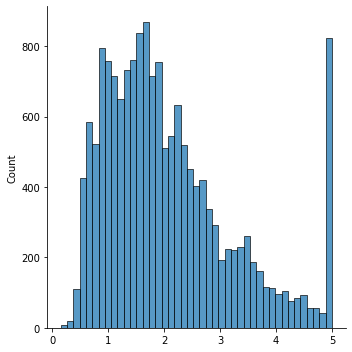

In [19]:
sns.displot(y_train)

# Distribution Selection

In [8]:
# Specifies Gamma distribution with exp response function and option to stabilize Gradient/Hessian. Type ?Gamma for an overview.
xgblss = XGBoostLSS(
     Gamma(stabilization="L2",     # Options are "None", "MAD", "L2".
          response_fn="exp",      # Function to transform the concentration and rate parameters, e.g., "exp" or "softplus".
          loss_fn="nll"           # Loss function. Options are "nll" (negative log-likelihood) or "crps"(continuous ranked probability score).
         )
)

# Hyper-Parameter Optimization

Any XGBoost hyperparameter can be tuned, where the structure of the parameter dictionary needs to be as follows:

    - Float/Int sample_type
        - {"param_name": ["sample_type", low, high, log]}
            - sample_type: str, Type of sampling, e.g., "float" or "int"
            - low: int, Lower endpoint of the range of suggested values
            - high: int, Upper endpoint of the range of suggested values
            - log: bool, Flag to sample the value from the log domain or not
        - Example: {"eta": "float", low=1e-5, high=1, log=True]}

    - Categorical sample_type
        - {"param_name": ["sample_type", ["choice1", "choice2", "choice3", "..."]]}
            - sample_type: str, Type of sampling, either "categorical"
            - choice1, choice2, choice3, ...: str, Possible choices for the parameter
        - Example: {"booster": ["categorical", ["gbtree", "dart"]]}

    - For parameters without tunable choice (this is needed if tree_method = "gpu_hist" and gpu_id needs to be specified)
        - {"param_name": ["none", [value]]},
            - param_name: str, Name of the parameter
            - value: int, Value of the parameter
        - Example: {"gpu_id": ["none", [0]]}

Depending on which parameters are optimized, it might happen that some of them are not used, e.g., when {"booster":  ["categorical", ["gbtree", "gblinear"]]} and {"max_depth": ["int", 1, 10, False]} are specified, max_depth is not used when gblinear is sampled, since it has no such argument.

In [10]:
param_dict = {
    "eta":              ["float", {"low": 1e-5,   "high": 1,     "log": True}],
    "max_depth":        ["int",   {"low": 1,      "high": 10,    "log": False}],
    "gamma":            ["float", {"low": 1e-8,   "high": 40,    "log": True}],
    "subsample":        ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "colsample_bytree": ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "min_child_weight": ["float", {"low": 1e-8,   "high": 500,   "log": True}],
    "booster":          ["categorical", ["gbtree"]],
    # "tree_method":    ["categorical", ["auto", "approx", "hist", "gpu_hist"]],
    # "gpu_id":         ["none", [0]]
}

np.random.seed(123)
opt_param = xgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=5,              # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=None,              # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=False,              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=None                # Seed for random number generator used in the Bayesian hyperparameter search.
                            )

[I 2023-11-26 06:35:16,519] A new study created in memory with name: XGBoostLSS Hyper-Parameter Optimization


   0%|          | 00:00/05:00

invalid value encountered in subtract


[I 2023-11-26 06:35:28,985] Trial 0 finished with value: 1693271.675 and parameters: {'eta': 0.6010790311124599, 'max_depth': 10, 'gamma': 2.090768507535599e-08, 'subsample': 0.3870858236698599, 'colsample_bytree': 0.4370814165605734, 'min_child_weight': 0.00011681435049797897, 'booster': 'gbtree'}. Best is trial 0 with value: 1693271.675.
[I 2023-11-26 06:36:13,854] Trial 1 finished with value: 4527.444043 and parameters: {'eta': 0.00021557777296864872, 'max_depth': 6, 'gamma': 0.09050241790157514, 'subsample': 0.7185918288350868, 'colsample_bytree': 0.5901049363506559, 'min_child_weight': 1.883236424017021e-05, 'booster': 'gbtree'}. Best is trial 1 with value: 4527.444043.
[I 2023-11-26 06:37:01,230] Trial 2 finished with value: 4623.3374998 and parameters: {'eta': 8.648112849723861e-05, 'max_depth': 7, 'gamma': 0.22152591157741863, 'subsample': 0.8087135775189722, 'colsample_bytree': 0.7189563703706843, 'min_child_weight': 0.056323898794263486, 'booster': 'gbtree'}. Best is trial 1 

# Model Training

In [11]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
xgblss.train(opt_params,
             dtrain,
             num_boost_round=n_rounds
             )

# Prediction

In [12]:
# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 1000
quant_sel = [0.05, 0.95] # Quantiles to calculate from predicted distribution

# Sample from predicted distribution
pred_samples = xgblss.predict(dtest,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = xgblss.predict(dtest,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Returns predicted distributional parameters
pred_params = xgblss.predict(dtest,
                             pred_type="parameters")

In [13]:
pred_samples.head()

,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,y_sample9,...,y_sample990,y_sample991,y_sample992,y_sample993,y_sample994,y_sample995,y_sample996,y_sample997,y_sample998,y_sample999
0,1.797746,2.573086,1.700387,1.758448,2.565567,1.177209,0.672318,2.030103,3.353246,1.724602,...,2.146900,1.890432,3.066054,1.343862,2.529183,2.862948,2.738793,1.162337,0.966042,2.117270
1,1.484954,0.680996,0.798661,2.808635,1.450603,1.193596,1.850755,1.029138,2.425506,0.342393,...,1.905235,0.461140,1.146236,1.354009,1.254875,0.941373,2.157014,0.177568,0.507697,1.885757
2,0.692506,1.521906,1.067351,1.003672,1.384315,1.332993,0.763097,0.884922,2.535422,1.168878,...,0.685750,1.811363,2.297762,1.292294,0.414267,0.511063,1.489506,1.004277,1.481280,1.035390
3,1.891097,1.957830,1.523541,1.143992,0.939788,0.951624,2.423627,3.404308,1.209876,2.786334,...,1.355711,2.519283,2.949226,1.729236,4.620703,2.283247,1.743145,1.758371,0.823073,1.210245
4,3.733439,2.311883,5.938832,2.562759,3.652133,2.582261,3.340943,1.958175,1.417115,2.037404,...,4.284501,4.281052,3.203784,3.764426,2.369098,2.838819,3.102988,3.253939,4.199548,5.075541


In [14]:
pred_quantiles.head()

,quant_0.05,quant_0.95
0,0.684786,4.154282
1,0.386685,3.151161
2,0.484656,3.321691
3,0.645205,3.628145
4,1.307643,6.108054


In [15]:
pred_params.head()

,concentration,rate
0,3.799423,1.814873
1,2.909791,1.868425
2,3.530766,2.164881
3,3.877243,2.090133
4,5.064327,1.465421


In [29]:
pred_params["mean"] = pred_params["concentration"] / pred_params["rate"]
pred_params["var"] = pred_params["mean"] / pred_params["rate"]

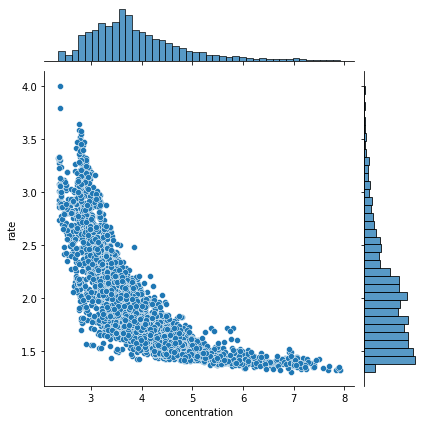

In [23]:
sns.jointplot(data=pred_params, x="concentration", y="rate")

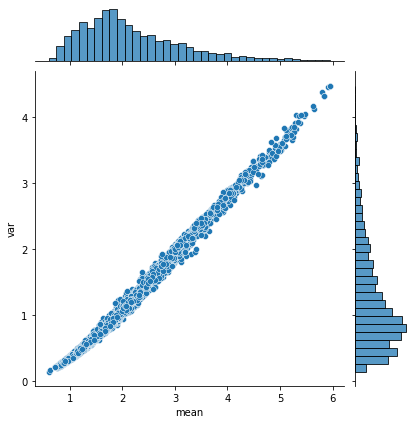

In [30]:
sns.jointplot(data=pred_params, x="mean", y="var")

# SHAP Interpretability

In [26]:
# Partial Dependence Plot
pdp_df = pd.DataFrame(X_train, columns=feature_names)

[06:49:03] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


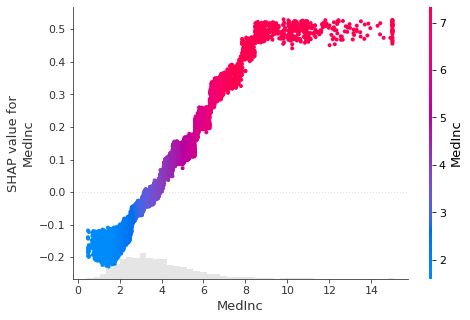

[06:49:06] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


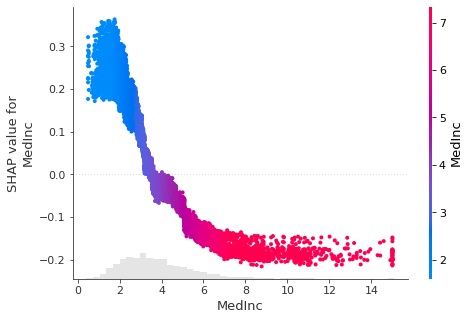

In [24]:

xgblss.plot(pdp_df,
            parameter="concentration",
            feature=feature_names[0],
            plot_type="Partial_Dependence")

xgblss.plot(pdp_df,
            parameter="rate",
            feature=feature_names[0],
            plot_type="Partial_Dependence")

[06:41:10] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


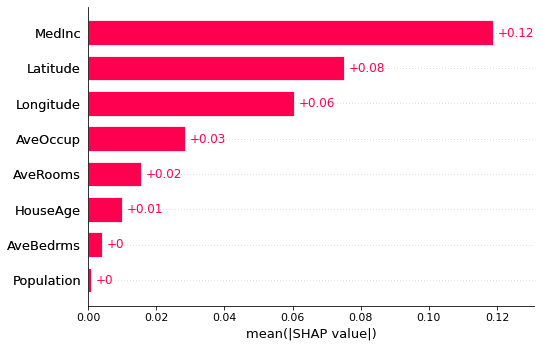

In [17]:
# Feature Importance
xgblss.plot(pdp_df,
            parameter="concentration",
            plot_type="Feature_Importance")